### Effect of calibration on Naive and ClassThr

This notebook is used to perform our calibration effect ablation experiment on our label set methods 'Naive' and 'ClassThr'. The experimental results are documented in Appendix C.1 in the paper. The experiment requires access to the logits of the object detector's classification head (see also model/fast_rcnn.py)

In [213]:
# import statements
import sys
sys.path.insert(0, "/home/atimans/Desktop/project_1/conformalbb")

import os
import importlib
import argparse
from pathlib import Path

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from detectron2.data import DatasetCatalog, MetadataCatalog, get_detection_dataset_dicts
from detectron2.utils.logger import setup_logger

from control import std_conformal, ens_conformal, cqr_conformal, baseline_conformal
from data import data_loader
from evaluation import metrics
from model import model_loader
from util import util, io_file

#### Set fixed params

In [217]:
args_dict = {
    "config_file": "cfg_std_rank",
    "config_path": "conformalbb/config/coco_val",
    "run_collect_pred": False,
    "load_collect_pred": "std_conf_x101fpn_std_rank_logits",
    "save_file_pred": False,
    "risk_control": "std_conf",
    "alpha": 0.1,
    "label_set": "class_threshold",
    "label_alpha": 0.01,
    "run_risk_control": True,
    "load_risk_control": None,
    "save_file_control": True,
    "save_label_set": True,
    "run_eval": True,
    "save_file_eval": True,
    "file_name_prefix": None,
    "file_name_suffix": "_std_rank_class_temp_acc",
    "log_wandb": False,
    "device": "cuda"
}
args = argparse.Namespace(**args_dict)

#### Run main setup

In [219]:
### Main setup
cfg = io_file.load_yaml(args.config_file, args.config_path, to_yacs=True)
data_name = cfg.DATASETS.DATASET.NAME
cfg.MODEL.AP_EVAL = False
cfg.PROJECT.OUTPUT_DIR = "output"

if args.file_name_prefix is not None:
    file_name_prefix = args.file_name_prefix
else:
    file_name_prefix = (f"{args.risk_control}_{cfg.MODEL.ID}{args.file_name_suffix}")
outdir = cfg.PROJECT.OUTPUT_DIR
filedir = os.path.join(outdir, data_name, file_name_prefix)
Path(filedir).mkdir(exist_ok=True, parents=True)

logger = setup_logger(output=filedir)
util.set_seed(cfg.PROJECT.SEED, logger=logger)
cfg, _ = util.set_device(cfg, "cpu", logger=logger)

if not DatasetCatalog.__contains__(data_name):
    data_loader.d2_register_dataset(cfg, logger=logger)

cfg_model, model = model_loader.d2_build_model(cfg, logger=logger)
model_loader.d2_load_model(cfg_model, model, logger=logger)

data_list = get_detection_dataset_dicts(data_name, filter_empty=cfg.DATASETS.DATASET.FILTER_EMPTY)
dataloader = data_loader.d2_load_dataset_from_dict(data_list, cfg, cfg_model, logger=logger)
metadata = MetadataCatalog.get(data_name).as_dict()
nr_class = len(metadata["thing_classes"])

logger.info(f"Init risk control procedure with '{args.risk_control}'...")
if args.risk_control == "std_conf":
    controller = std_conformal.StdConformal(
        cfg, args, nr_class, filedir, log=None, logger=logger
    )
elif args.risk_control == "ens_conf":
    controller = ens_conformal.EnsConformal(
        cfg, args, nr_class, filedir, log=None, logger=logger
    )
elif args.risk_control == "cqr_conf":
    controller = cqr_conformal.CQRConformal(
        cfg, args, nr_class, filedir, log=None, logger=logger
    )
elif args.risk_control == "base_conf":
    controller = baseline_conformal.BaselineConformal(
        cfg, args, nr_class, filedir, log=None, logger=logger
    )

controller.set_collector(nr_class, len(data_list))

Loaded YAML file from conformalbb/config/coco_val/cfg_std_rank.yaml into <class 'detectron2.config.config.CfgNode'>.
[11/07 09:28:30 detectron2]: Setting seed=6666666.
[11/07 09:28:30 detectron2]: Setting seed=6666666.
[11/07 09:28:30 detectron2]: Setting seed=6666666.
[11/07 09:28:30 detectron2]: Setting seed=6666666.
[11/07 09:28:30 detectron2]: Setting seed=6666666.
[11/07 09:28:30 detectron2]: Requested device='cpu'.
[11/07 09:28:30 detectron2]: Requested device='cpu'.
[11/07 09:28:30 detectron2]: Requested device='cpu'.
[11/07 09:28:30 detectron2]: Requested device='cpu'.
[11/07 09:28:30 detectron2]: Requested device='cpu'.
[11/07 09:28:30 detectron2]: 'cpu' requested but 'cuda' is available.
[11/07 09:28:30 detectron2]: 'cpu' requested but 'cuda' is available.
[11/07 09:28:30 detectron2]: 'cpu' requested but 'cuda' is available.
[11/07 09:28:30 detectron2]: 'cpu' requested but 'cuda' is available.
[11/07 09:28:30 detectron2]: 'cpu' requested but 'cuda' is available.


[11/07 09:28:30 detectron2]: Set model weights path to 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'.
[11/07 09:28:30 detectron2]: Set model weights path to 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'.
[11/07 09:28:30 detectron2]: Set model weights path to 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'.
[11/07 09:28:30 detectron2]: Set model weights path to 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'.
[11/07 09:28:30 detectron2]: Set model weights path to 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'.
[11/07 09:28:32 detectron2]: Constructed cfg_model file and from it built model 'Faster R-CNN X101-FPN'.


In [220]:
# load pred files
pred_filedir = os.path.join(outdir, data_name, args.load_collect_pred)
img_list = io_file.load_json(f"{args.load_collect_pred}_img_list", pred_filedir)
ist_list = io_file.load_json(f"{args.load_collect_pred}_ist_list", pred_filedir)

# sanity checks
assert "pred_logits_all" in list(ist_list[0].keys()), "Missing pred_logits_all in ist_list"

assert torch.allclose(torch.tensor(ist_list[0]["pred_score_all"]) / torch.tensor(ist_list[0]["pred_score_all"]).sum(dim=1, keepdim=True), 
                      torch.nn.functional.softmax(torch.tensor(ist_list[0]["pred_logits_all"]), dim=1)
                      , atol=1e-5), "pred_score_all not consistent with pred_logits_all"

Loaded JSON file from output/coco_val/std_conf_x101fpn_std_rank_logits/std_conf_x101fpn_std_rank_logits_img_list.json.
Loaded JSON file from output/coco_val/std_conf_x101fpn_std_rank_logits/std_conf_x101fpn_std_rank_logits_ist_list.json.


#### ECE computations

In [221]:
# NOTE: ECE metric value is computed in metrics.ece

def compute_ece_for_class(ist_list, class_idx, bins=15):
    # ece over ist from a single class
    logits = torch.tensor(ist_list[class_idx]["pred_logits_all"])
    probs = F.softmax(logits, dim=1)
    preds = probs.argmax(dim=1)
    labels = torch.full(preds.shape, class_idx)
    return metrics.ece(probs, labels, bins).item()


def compute_ece(ist_list, bins=15):
    # ece over ist from all classes combined
    all_logits = torch.cat([torch.tensor(ist_list[c]["pred_logits_all"]) for c in range(nr_class)])
    all_probs = torch.nn.functional.softmax(all_logits, dim=1)
    all_preds = all_probs.argmax(dim=1)
    all_labels = torch.cat([torch.full((len(ist_list[c]["img_id"]),), c) for c in range(nr_class)])
    return metrics.ece(all_probs, all_labels, bins).item()


def compute_weighted_ece(ist_list, bins=15):
    # ece as weighted mean over ece per class, weights are class frequencies
    nr_ists = [len(ist_list[c]["img_id"]) for c in range(nr_class)]
    class_weights = torch.tensor(nr_ists) / sum(nr_ists)
    ece_per_class = torch.zeros(nr_class)
    for c in range(nr_class):
        ece_per_class[c] = compute_ece_for_class(ist_list, c, bins)
    return (ece_per_class * class_weights).sum().item()

In [222]:
# Model ECE without temperature scaling
print("ECE per class:", [round(compute_ece_for_class(ist_list, c, bins=15),4) for c in range(nr_class)])
print("Weighted ECE:", round(compute_weighted_ece(ist_list, bins=15), 4))
print("ECE:", round(compute_ece(ist_list, bins=15), 4))

ECE per class: [0.0011, 0.0093, 0.015, 0.0274, 0.0088, 0.0488, 0.0432, 0.2139, 0.0125, 0.0031, 0.0052, 0.0023, 0.081, 0.0429, 0.0209, 0.0348, 0.0884, 0.0589, 0.0404, 0.049, 0.017, 0.0571, 0.0034, 0.0051, 0.1088, 0.0046, 0.0655, 0.0078, 0.024, 0.0329, 0.0271, 0.1987, 0.0094, 0.0138, 0.0307, 0.0071, 0.0138, 0.0193, 0.0326, 0.0338, 0.0695, 0.048, 0.1017, 0.0629, 0.0954, 0.0524, 0.0222, 0.0577, 0.1364, 0.0672, 0.008, 0.024, 0.1923, 0.0316, 0.0445, 0.0796, 0.0361, 0.1359, 0.0041, 0.0809, 0.0452, 0.022, 0.0204, 0.063, 0.0028, 0.0477, 0.017, 0.0698, 0.0848, 0.0622, 0.1736, 0.0179, 0.0184, 0.0167, 0.0176, 0.0677, 0.0212, 0.0303, 0.162, 0.0191]
Weighted ECE: 0.0268
ECE: 0.022


#### Temperature scaling

In [10]:
"""
Define temperature range
T > 1: make model less confident
T = 1: keep model confidence as is
T < 1: make model more confident
"""

# 100 values in range 0-1, 100 values in range 1-11
temps = np.concatenate((np.arange(0.01, 1.01, 0.01), np.arange(1.1, 11.1, 0.1)))

logits = torch.cat([torch.tensor(ist_list[c]["pred_logits_all"]) for c in range(nr_class)])
probs = torch.nn.functional.softmax(logits, dim=1)
preds = probs.argmax(dim=1)
labels = torch.cat([torch.full((len(ist_list[c]["img_id"]),), c) for c in range(nr_class)])

In [11]:
def compute_optimal_temp(temps, logits, labels, to_plot: bool = True):
    ece_per_temp = {}
    
    for temp in temps:
        temp_logits = torch.div(logits, temp)
        temp_probs = F.softmax(temp_logits, dim=1)
        ece_per_temp[temp] = metrics.ece(temp_probs, labels).item()
    
    temp_opt_idx = torch.tensor(list(ece_per_temp.values())).argmin()
    temp_opt_val = temps[temp_opt_idx]
    ece_opt_val = list(ece_per_temp.values())[temp_opt_idx]
    
    print(f"Optimal Temp: {round(temp_opt_val, 4)}")
    print(f"ECE: {round(ece_opt_val, 4)}")
    
    if to_plot:
        plt.plot(list(ece_per_temp.keys()), list(ece_per_temp.values()))
        plt.xlabel("Temperature")
        plt.ylabel("ECE")
        plt.vlines(temp_opt_val, 0, 1, color="r", linestyles="dashed", label=f"Optimal Temp: {round(temp_opt_val, 4)}")
        plt.vlines(1, 0, 1, color="black", linestyles="dashed", label="Temp: 1")
        plt.legend(loc="lower right")
        plt.savefig(f'{filedir}/ece_per_temp.png', dpi=300, format="png", bbox_inches="tight")
    
    return ece_per_temp, temp_opt_val, ece_opt_val
    

Optimal Temp: 1.3
ECE: 0.0079


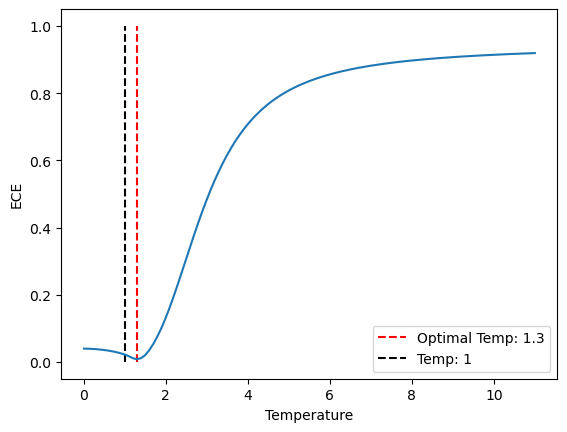

In [12]:
ece_per_temp, temp_opt_val, ece_opt_val = compute_optimal_temp(temps, logits, labels, to_plot=True)

ece_per_temp_df = pd.DataFrame(list(ece_per_temp.items()), columns=['temperature', 'ece'])
ece_per_temp_df.to_csv(f'{filedir}/ece_per_temp.csv', index=False, float_format="%.4f")

In [ ]:
# run risk control with 'Naive' label set method for different temperatures and collect results

# Reduce the number of temperatures to speed up the process
temps = np.concatenate((np.arange(0.1, 1.0, 0.1), np.arange(1.0, 10.1, 1)))

for temp in temps:
    print(f"####### Temp: {round(temp, 4)}")
    
    temp_list = ist_list.copy()
    for c in range(nr_class):
            temp_logits = torch.div(torch.tensor(ist_list[c]["pred_logits_all"]), temp)
            temp_list[c]["pred_logits_all"] = temp_logits.tolist()
            temp_list[c]["pred_score_all"] = F.softmax(temp_logits, dim=1).tolist()

    control_data, test_indices, label_sets, label_data, box_set_data = controller(
        img_list, temp_list
    )
    
    temp_dir = os.path.join(filedir, f"temp_{round(temp, 4)}")
    Path(temp_dir).mkdir(exist_ok=True, parents=True)
    
    controller.evaluate(
        control_data,
        label_data,
        box_set_data,
        metadata,
        temp_dir,
        args.save_file_eval,
        args.load_collect_pred,
    )

In [14]:
paths_box_set = [os.path.join(filedir, f"temp_{round(temp, 4)}", f"temp_{round(temp, 4)}_box_set_table_abs_res.csv") for temp in temps]
paths_labels = [os.path.join(filedir, f"temp_{round(temp, 4)}", f"temp_{round(temp, 4)}_label_table.csv") for temp in temps]

In [ ]:
box_rows = 4
box_cols = ["mpiw", "box stretch", "cov box"]
box_res_name = "box_metrics_per_temp"

label_rows = 4
label_cols = ["mean set size", "cov set"]
label_res_name = "label_metrics_per_temp"

In [ ]:
df_box_set = pd.DataFrame()

for i, path in enumerate(paths_box_set):
    df = pd.read_csv(path)
    
    row_selected = df.loc[box_rows, box_cols]
    row_selected.fillna("--", inplace=True)
    row_selected = pd.concat([pd.Series([temps[i]], index=["temperature"]), row_selected.loc[:]])
    
    df_box_set = pd.concat([df_box_set, row_selected.to_frame().T], ignore_index=True)
    
df_box_set.to_csv(f'{filedir}/{box_res_name}.csv', index=False, float_format="%.4f")

In [ ]:
df_label_set = pd.DataFrame()

for i, path in enumerate(paths_labels):
    df = pd.read_csv(path)
    
    row_selected = df.loc[label_rows, label_cols]
    row_selected.fillna("--", inplace=True)
    row_selected = pd.concat([pd.Series([temps[i]], index=["temperature"]), row_selected.loc[:]])
    
    df_label_set = pd.concat([df_label_set, row_selected.to_frame().T], ignore_index=True)
    
df_label_set.to_csv(f'{filedir}/{label_res_name}.csv', index=False, float_format="%.4f")

In [242]:
# run risk control with 'ClassThr' label set method for different temperatures and collect results

# Reduce the number of temperatures to speed up the process
temps = np.concatenate((np.arange(0.1, 1.0, 0.1), np.arange(1.0, 10.1, 1)))

for temp in temps:
    print(f"####### Temp: {round(temp, 4)}")
    
    temp_list = ist_list.copy()
    for c in range(nr_class):
            log = torch.tensor(ist_list[c]["pred_logits_all"])
            logits_red = log + torch.rand(log.shape) * n
            temp_logits = torch.div(logits_red, temp)
            temp_list[c]["pred_logits_all"] = temp_logits.tolist()
            temp_list[c]["pred_score_all"] = F.softmax(temp_logits, dim=1).tolist()

    control_data, test_indices, label_sets, label_data, box_set_data = controller(
        img_list, temp_list
    )
    
    temp_dir = os.path.join(filedir, f"temp_{round(temp, 4)}")
    Path(temp_dir).mkdir(exist_ok=True, parents=True)
    
    controller.evaluate(
        control_data,
        label_data,
        box_set_data,
        metadata,
        temp_dir,
        args.save_file_eval,
        args.load_collect_pred,
    )
 

####### Temp: 0.1
[11/07 09:30:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:30:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:30:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:30:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:30:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]

[11/07 09:32:27 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:32:27 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:32:27 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:32:27 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:32:27 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [05:04<00:00,  3.04s/it]

[11/07 09:37:32 detectron2]: Collecting and computing results...
[11/07 09:37:32 detectron2]: Collecting and computing results...
[11/07 09:37:32 detectron2]: Collecting and computing results...
[11/07 09:37:32 detectron2]: Collecting and computing results...
[11/07 09:37:32 detectron2]: Collecting and computing results...
[11/07 09:37:32 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:37:32 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:37:32 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:37:32 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:37:32 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:37:32 detectron2]: Written results to temp_0.1_res_table_abs_res.
[11/07 09:37:32 detectron2]: Written results to temp_0.1_re

####### Temp: 0.2
[11/07 09:37:33 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:37:33 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:37:33 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:37:33 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:37:33 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

[11/07 09:39:09 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:39:09 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:39:09 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:39:09 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:39:09 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:57<00:00,  2.97s/it]

[11/07 09:44:06 detectron2]: Collecting and computing results...
[11/07 09:44:06 detectron2]: Collecting and computing results...
[11/07 09:44:06 detectron2]: Collecting and computing results...
[11/07 09:44:06 detectron2]: Collecting and computing results...
[11/07 09:44:06 detectron2]: Collecting and computing results...
[11/07 09:44:06 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:44:06 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:44:06 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:44:06 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:44:06 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:44:06 detectron2]: Written results to temp_0.2_res_table_abs_res.
[11/07 09:44:06 detectron2]: Written results to temp_0.2_re

####### Temp: 0.3
[11/07 09:44:07 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:44:07 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:44:07 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:44:07 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:44:07 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]

[11/07 09:45:43 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:45:43 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:45:43 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:45:43 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:45:43 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [05:06<00:00,  3.07s/it]

[11/07 09:50:50 detectron2]: Collecting and computing results...
[11/07 09:50:50 detectron2]: Collecting and computing results...
[11/07 09:50:50 detectron2]: Collecting and computing results...
[11/07 09:50:50 detectron2]: Collecting and computing results...
[11/07 09:50:50 detectron2]: Collecting and computing results...
[11/07 09:50:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:50:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:50:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:50:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:50:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:50:50 detectron2]: Written results to temp_0.3_res_table_abs_res.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_re

[11/07 09:50:50 detectron2]: Written results to temp_0.3_res_table_one_sided_res.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_res_table_one_sided_res.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_res_table_one_sided_res.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_res_table_one_sided_res.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_res_table_one_sided_res.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_label_table.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_label_table.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_label_table.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_label_table.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_label_table.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_box_set_table_one_sided_res.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_box_set_table_one_sided_res.
[11/07 09:50:50 detectron2]: Written results to temp_0.3_box_set_tab

Trials: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

[11/07 09:52:27 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:52:27 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:52:27 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:52:27 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:52:27 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:55<00:00,  2.96s/it]

[11/07 09:57:23 detectron2]: Collecting and computing results...
[11/07 09:57:23 detectron2]: Collecting and computing results...
[11/07 09:57:23 detectron2]: Collecting and computing results...
[11/07 09:57:23 detectron2]: Collecting and computing results...
[11/07 09:57:23 detectron2]: Collecting and computing results...
[11/07 09:57:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:57:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:57:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:57:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:57:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 09:57:23 detectron2]: Written results to temp_0.4_res_table_abs_res.
[11/07 09:57:23 detectron2]: Written results to temp_0.4_re

####### Temp: 0.5
[11/07 09:57:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:57:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:57:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:57:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 09:57:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

[11/07 09:58:58 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:58:58 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:58:58 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:58:58 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 09:58:58 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:50<00:00,  2.90s/it]

[11/07 10:03:48 detectron2]: Collecting and computing results...
[11/07 10:03:48 detectron2]: Collecting and computing results...
[11/07 10:03:48 detectron2]: Collecting and computing results...
[11/07 10:03:48 detectron2]: Collecting and computing results...
[11/07 10:03:48 detectron2]: Collecting and computing results...
[11/07 10:03:48 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:03:48 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:03:48 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:03:48 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:03:48 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:03:48 detectron2]: Written results to temp_0.5_res_table_abs_res.
[11/07 10:03:48 detectron2]: Written results to temp_0.5_re

####### Temp: 0.6
[11/07 10:03:49 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:03:49 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:03:49 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:03:49 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:03:49 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

[11/07 10:05:23 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:05:23 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:05:23 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:05:23 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:05:23 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [05:00<00:00,  3.00s/it]

[11/07 10:10:23 detectron2]: Collecting and computing results...
[11/07 10:10:23 detectron2]: Collecting and computing results...
[11/07 10:10:23 detectron2]: Collecting and computing results...
[11/07 10:10:23 detectron2]: Collecting and computing results...
[11/07 10:10:23 detectron2]: Collecting and computing results...
[11/07 10:10:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:10:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:10:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:10:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:10:23 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:10:23 detectron2]: Written results to temp_0.6_res_table_abs_res.
[11/07 10:10:23 detectron2]: Written results to temp_0.6_re

####### Temp: 0.7
[11/07 10:10:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:10:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:10:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:10:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:10:24 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

[11/07 10:12:00 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:12:00 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:12:00 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:12:00 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:12:00 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [05:02<00:00,  3.03s/it]

[11/07 10:17:03 detectron2]: Collecting and computing results...
[11/07 10:17:03 detectron2]: Collecting and computing results...
[11/07 10:17:03 detectron2]: Collecting and computing results...
[11/07 10:17:03 detectron2]: Collecting and computing results...
[11/07 10:17:03 detectron2]: Collecting and computing results...
[11/07 10:17:03 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:17:03 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:17:03 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:17:03 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:17:03 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:17:03 detectron2]: Written results to temp_0.7_res_table_abs_res.
[11/07 10:17:03 detectron2]: Written results to temp_0.7_re

####### Temp: 0.8
[11/07 10:17:04 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:17:04 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:17:04 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:17:04 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:17:04 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]

[11/07 10:18:39 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:18:39 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:18:39 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:18:39 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:18:39 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:56<00:00,  2.96s/it]

[11/07 10:23:36 detectron2]: Collecting and computing results...
[11/07 10:23:36 detectron2]: Collecting and computing results...
[11/07 10:23:36 detectron2]: Collecting and computing results...
[11/07 10:23:36 detectron2]: Collecting and computing results...
[11/07 10:23:36 detectron2]: Collecting and computing results...
[11/07 10:23:36 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:23:36 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:23:36 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:23:36 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:23:36 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:23:36 detectron2]: Written results to temp_0.8_res_table_abs_res.
[11/07 10:23:36 detectron2]: Written results to temp_0.8_re

####### Temp: 0.9
[11/07 10:23:37 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:23:37 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:23:37 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:23:37 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:23:37 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]

[11/07 10:25:09 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:25:09 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:25:09 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:25:09 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:25:09 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:59<00:00,  3.00s/it]

[11/07 10:30:09 detectron2]: Collecting and computing results...
[11/07 10:30:09 detectron2]: Collecting and computing results...
[11/07 10:30:09 detectron2]: Collecting and computing results...
[11/07 10:30:09 detectron2]: Collecting and computing results...
[11/07 10:30:09 detectron2]: Collecting and computing results...
[11/07 10:30:09 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:30:09 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:30:09 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:30:09 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:30:09 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:30:09 detectron2]: Written results to temp_0.9_res_table_abs_res.
[11/07 10:30:09 detectron2]: Written results to temp_0.9_re

####### Temp: 1.0
[11/07 10:30:10 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:30:10 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:30:10 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:30:10 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:30:10 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]

[11/07 10:31:52 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:31:52 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:31:52 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:31:52 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:31:52 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [05:07<00:00,  3.08s/it]

[11/07 10:37:00 detectron2]: Collecting and computing results...
[11/07 10:37:00 detectron2]: Collecting and computing results...
[11/07 10:37:00 detectron2]: Collecting and computing results...
[11/07 10:37:00 detectron2]: Collecting and computing results...
[11/07 10:37:00 detectron2]: Collecting and computing results...
[11/07 10:37:00 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:37:00 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:37:00 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:37:00 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:37:00 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:37:00 detectron2]: Written results to temp_1.0_res_table_abs_res.
[11/07 10:37:00 detectron2]: Written results to temp_1.0_re

####### Temp: 2.0
[11/07 10:37:01 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:37:01 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:37:01 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:37:01 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:37:01 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:32<00:00,  1.09it/s]

[11/07 10:38:33 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:38:33 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:38:33 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:38:33 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:38:33 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:51<00:00,  2.92s/it]

[11/07 10:43:25 detectron2]: Collecting and computing results...
[11/07 10:43:25 detectron2]: Collecting and computing results...
[11/07 10:43:25 detectron2]: Collecting and computing results...
[11/07 10:43:25 detectron2]: Collecting and computing results...
[11/07 10:43:25 detectron2]: Collecting and computing results...
[11/07 10:43:25 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:43:25 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:43:25 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:43:25 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:43:25 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:43:25 detectron2]: Written results to temp_2.0_res_table_abs_res.
[11/07 10:43:25 detectron2]: Written results to temp_2.0_re

####### Temp: 3.0
[11/07 10:43:25 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:43:25 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:43:25 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:43:25 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:43:25 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

[11/07 10:45:00 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:45:00 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:45:00 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:45:00 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:45:00 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:40<00:00,  2.81s/it]

[11/07 10:49:41 detectron2]: Collecting and computing results...
[11/07 10:49:41 detectron2]: Collecting and computing results...
[11/07 10:49:41 detectron2]: Collecting and computing results...
[11/07 10:49:41 detectron2]: Collecting and computing results...
[11/07 10:49:41 detectron2]: Collecting and computing results...
[11/07 10:49:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:49:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:49:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:49:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:49:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:49:41 detectron2]: Written results to temp_3.0_res_table_abs_res.
[11/07 10:49:41 detectron2]: Written results to temp_3.0_re

####### Temp: 4.0
[11/07 10:49:42 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:49:42 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:49:42 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:49:42 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:49:42 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

[11/07 10:51:15 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:51:15 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:51:15 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:51:15 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:51:15 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [05:02<00:00,  3.03s/it]

[11/07 10:56:18 detectron2]: Collecting and computing results...
[11/07 10:56:18 detectron2]: Collecting and computing results...
[11/07 10:56:18 detectron2]: Collecting and computing results...
[11/07 10:56:18 detectron2]: Collecting and computing results...
[11/07 10:56:18 detectron2]: Collecting and computing results...
[11/07 10:56:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:56:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:56:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:56:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:56:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 10:56:18 detectron2]: Written results to temp_4.0_res_table_abs_res.
[11/07 10:56:18 detectron2]: Written results to temp_4.0_re

####### Temp: 5.0
[11/07 10:56:19 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:56:19 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:56:19 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:56:19 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 10:56:19 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]

[11/07 10:57:52 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:57:52 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:57:52 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:57:52 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 10:57:52 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:57<00:00,  2.97s/it]

[11/07 11:02:50 detectron2]: Collecting and computing results...
[11/07 11:02:50 detectron2]: Collecting and computing results...
[11/07 11:02:50 detectron2]: Collecting and computing results...
[11/07 11:02:50 detectron2]: Collecting and computing results...
[11/07 11:02:50 detectron2]: Collecting and computing results...
[11/07 11:02:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:02:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:02:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:02:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:02:50 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:02:50 detectron2]: Written results to temp_5.0_res_table_abs_res.
[11/07 11:02:50 detectron2]: Written results to temp_5.0_re

####### Temp: 6.0
[11/07 11:02:50 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:02:50 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:02:50 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:02:50 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:02:50 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

[11/07 11:04:24 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:04:24 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:04:24 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:04:24 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:04:24 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:53<00:00,  2.93s/it]

[11/07 11:09:18 detectron2]: Collecting and computing results...
[11/07 11:09:18 detectron2]: Collecting and computing results...
[11/07 11:09:18 detectron2]: Collecting and computing results...
[11/07 11:09:18 detectron2]: Collecting and computing results...
[11/07 11:09:18 detectron2]: Collecting and computing results...
[11/07 11:09:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:09:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:09:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:09:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:09:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:09:18 detectron2]: Written results to temp_6.0_res_table_abs_res.
[11/07 11:09:18 detectron2]: Written results to temp_6.0_re

####### Temp: 7.0
[11/07 11:09:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:09:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:09:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:09:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:09:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]

[11/07 11:10:53 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:10:53 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:10:53 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:10:53 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:10:53 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:51<00:00,  2.92s/it]

[11/07 11:15:45 detectron2]: Collecting and computing results...
[11/07 11:15:45 detectron2]: Collecting and computing results...
[11/07 11:15:45 detectron2]: Collecting and computing results...
[11/07 11:15:45 detectron2]: Collecting and computing results...
[11/07 11:15:45 detectron2]: Collecting and computing results...
[11/07 11:15:45 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:15:45 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:15:45 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:15:45 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:15:45 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:15:45 detectron2]: Written results to temp_7.0_res_table_abs_res.
[11/07 11:15:45 detectron2]: Written results to temp_7.0_re

####### Temp: 8.0
[11/07 11:15:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:15:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:15:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:15:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:15:46 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]

[11/07 11:17:22 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:17:22 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:17:22 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:17:22 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:17:22 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:55<00:00,  2.96s/it]

[11/07 11:22:18 detectron2]: Collecting and computing results...
[11/07 11:22:18 detectron2]: Collecting and computing results...
[11/07 11:22:18 detectron2]: Collecting and computing results...
[11/07 11:22:18 detectron2]: Collecting and computing results...
[11/07 11:22:18 detectron2]: Collecting and computing results...
[11/07 11:22:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:22:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:22:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:22:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:22:18 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:22:18 detectron2]: Written results to temp_8.0_res_table_abs_res.
[11/07 11:22:18 detectron2]: Written results to temp_8.0_re

####### Temp: 9.0
[11/07 11:22:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:22:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:22:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:22:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:22:18 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]

[11/07 11:23:51 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:23:51 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:23:51 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:23:51 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:23:51 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:49<00:00,  2.90s/it]

[11/07 11:28:41 detectron2]: Collecting and computing results...
[11/07 11:28:41 detectron2]: Collecting and computing results...
[11/07 11:28:41 detectron2]: Collecting and computing results...
[11/07 11:28:41 detectron2]: Collecting and computing results...
[11/07 11:28:41 detectron2]: Collecting and computing results...
[11/07 11:28:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:28:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:28:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:28:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:28:41 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:28:41 detectron2]: Written results to temp_9.0_res_table_abs_res.
[11/07 11:28:41 detectron2]: Written results to temp_9.0_re

####### Temp: 10.0
[11/07 11:28:41 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:28:41 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:28:41 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:28:41 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            
[11/07 11:28:41 detectron2]: 
            Running risk control procedure for 100 trials...
            Calibration fraction: 0.5, alpha: 0.1,
            box correction: rank_coord.
            


Trials: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

[11/07 11:30:16 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:30:16 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:30:16 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:30:16 detectron2]: 
            Running label set procedure for 100 trials...
            Label set strategy: class_threshold / ClassThresholdSet,
            box set strategy: max, label set alpha: 0.01.
            
[11/07 11:30:16 detectron2]: 
            Running label set procedure for 100 trials...



Trials: 100%|██████████| 100/100 [04:54<00:00,  2.95s/it]

[11/07 11:35:10 detectron2]: Collecting and computing results...
[11/07 11:35:10 detectron2]: Collecting and computing results...
[11/07 11:35:10 detectron2]: Collecting and computing results...
[11/07 11:35:10 detectron2]: Collecting and computing results...
[11/07 11:35:10 detectron2]: Collecting and computing results...
[11/07 11:35:10 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:35:10 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:35:10 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:35:10 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:35:10 detectron2]: Evaluating for scores ['abs_res_x0', 'abs_res_y0', 'abs_res_x1', 'abs_res_y1']
[11/07 11:35:10 detectron2]: Written results to temp_10.0_res_table_abs_res.
[11/07 11:35:10 detectron2]: Written results to temp_10.0_

In [243]:
# temps = np.concatenate((np.arange(0.1, 1.1, 0.1), np.arange(2.0, 10.1, 1)))
paths_box_set = [os.path.join(filedir, f"temp_{round(temp, 4)}", f"temp_{round(temp, 4)}_box_set_table_abs_res.csv") for temp in temps]
paths_labels = [os.path.join(filedir, f"temp_{round(temp, 4)}", f"temp_{round(temp, 4)}_label_table.csv") for temp in temps]

In [244]:
box_rows = 4
box_cols = ["mpiw", "box stretch", "cov box"]
box_res_name = "box_metrics_per_temp"

label_rows = 4
label_cols = ["mean set size", "cov set"]
label_res_name = "label_metrics_per_temp"

In [245]:
df_box_set = pd.DataFrame()

for i, path in enumerate(paths_box_set):
    df = pd.read_csv(path)
    
    row_selected = df.loc[box_rows, box_cols]
    row_selected.fillna("--", inplace=True)
    row_selected = pd.concat([pd.Series([temps[i]], index=["temperature"]), row_selected.loc[:]])
    
    df_box_set = pd.concat([df_box_set, row_selected.to_frame().T], ignore_index=True)
    
df_box_set.to_csv(f'{filedir}/{box_res_name}.csv', index=False, float_format="%.4f")

In [246]:
df_label_set = pd.DataFrame()

for i, path in enumerate(paths_labels):
    df = pd.read_csv(path)
    
    row_selected = df.loc[label_rows, label_cols]
    row_selected.fillna("--", inplace=True)
    row_selected = pd.concat([pd.Series([temps[i]], index=["temperature"]), row_selected.loc[:]])
    
    df_label_set = pd.concat([df_label_set, row_selected.to_frame().T], ignore_index=True)
    
df_label_set.to_csv(f'{filedir}/{label_res_name}.csv', index=False, float_format="%.4f")